In [542]:
import random
import itertools as it
from pathlib import Path

import mido
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F

import geotorch

In [292]:
data_dir = Path('/Users/victor/Downloads/lmd_full')

In [474]:
files = list(data_dir.glob('**/*.mid'))

In [741]:
# %%timeit
# for _ in range(32):
#     f = open(random.choice(files), 'rb')
#     data = f.read()

10.9 ms ± 913 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [743]:
# %%timeit
# for _ in range(32):
#     mido.MidiFile(random.choice(files))

2.31 s ± 262 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [493]:
len(files)

178561

In [703]:
random.shuffle(files)

In [495]:
min_len = 64

In [704]:
# takes about 30 min to do 10000 files
seqs = []
for f in tqdm(it.islice(files, 10000)):
    try:
        mid = mido.MidiFile(f)
    except Exception:
        continue
    for tr in mid.tracks:
        seq = [m.note for m in tr if m.type=='note_on' and m.velocity]
        if len(seq) > min_len:
            seqs.append(seq)

10000it [30:09,  5.53it/s]


In [705]:
len(seqs)

43545

In [571]:
# mid = mido.MidiFile(random.choice(files))

In [570]:
# [m for m in mid.tracks[2] if m.type=='note_on' and m.velocity]

In [503]:
# %%timeit
# for _ in range(100):
#     try:
#         mid = mido.MidiFile(random.choice(files))
#     except:
#         continue

In [706]:
# def gen_tracks(batch_len=100):
#     while True:
#         try:
#             mid = mido.MidiFile(random.choice(files))
#         except Exception:
#             continue
#         trs = [tr for tr in mid.tracks if len(tr) > batch_len*2]
#         if len(trs)==0:
#             continue
#         random.shuffle(trs)
#         for tr in trs:
#             notes = [m.note for m in tr if m.type=='note_on']
#             if len(notes) > batch_len:
#                 i = random.randint(0, len(notes)-batch_len-1)
#                 yield notes[i:i+batch_len]
#                 break
                
# class LakhMIDI(torch.utils.data.IterableDataset):
#     def __init__(self, batch_len):
#         super().__init__()
#         self.batch_len = batch_len
        
#     def __iter__(self):
#         return gen_tracks(self.batch_len)

class LakhMIDI(torch.utils.data.IterableDataset):
    def __init__(self, seqs, batch_len=None):
        super().__init__()
        self.seqs = seqs
        self.batch_len = batch_len
        
    def __iter__(self):
        return self
    
    def __next__(self):
        while True:
            notes = random.choice(self.seqs)
            if len(notes) > self.batch_len:
                i = random.randint(0, len(notes)-self.batch_len-1)
                return notes[i:i+self.batch_len]

In [707]:
dl = torch.utils.data.DataLoader(LakhMIDI(seqs, 64), batch_size=32, num_workers=0, collate_fn=torch.LongTensor)

In [708]:
next(iter(dl)).shape

torch.Size([32, 64])

In [535]:
# %%prun
# list(it.islice(gen_tracks(64), 32))

In [421]:
# logits = torch.randn(32,64,128)
# c = torch.randint(0, 128, (32,64))

In [422]:
# %%timeit
# F.nll_loss(logits.transpose(1,2), c)

In [423]:
# %%timeit
# -logits.gather(-1, c[...,None]).mean()

In [424]:
# %%timeit
# F.log_softmax(logits, -1)

In [425]:
# %%timeit
# logits - logits.logsumexp(-1, keepdim=True)

In [709]:
class PitchPredictor(nn.Module):
    def __init__(self, emb_size=128, hidden_size=512, domain_size=128):
        super().__init__()
        self.emb = nn.Embedding(domain_size, emb_size)
        self.proj = nn.Linear(hidden_size, domain_size)
        
        self.rnn = nn.GRU(emb_size, hidden_size, batch_first=True)
        self.rnn_cell = nn.GRUCell(emb_size, hidden_size)
        self.rnn_cell.weight_ih = self.rnn.weight_ih_l0
        self.rnn_cell.weight_hh = self.rnn.weight_hh_l0
        self.rnn_cell.bias_ih = self.rnn.bias_ih_l0
        self.rnn_cell.bias_hh = self.rnn.bias_hh_l0
        
        self.h0 = torch.nn.Parameter(torch.randn(1,hidden_size)*hidden_size**-0.5)
        
        self.h = None

        
    def forward(self, notes):
        """
        Args:
            notes: LongTensor[batch, time]
        """
        x = self.emb(notes) # batch, time, emb_size
        h, _ = self.rnn(x, self.h0[None].expand(1, x.shape[0], -1)) #batch, time, hidden_size
        logits = self.proj(h[:,:-1]) # batch, time-1, 128
        logits = F.log_softmax(logits, -1) # logits = logits - logits.logsumexp(-1, keepdim=True)
        targets = notes[:,1:,None] #batch, time-1, 1
        return {
            'log_probs': logits.gather(-1, targets)[...,0],
            'logits': logits
        }
    
    def predict(self, note, sample=True):
        """
        Args:
            note: int
            sample: bool
        Returns:
            int if `sample` else Tensor[domain_size]
        """
        note = torch.LongTensor([note]) # 1
        x = self.emb(note) # 1, emb_size
        
        if self.h is None:
            self.h = self.h0.detach().clone()
        
        self.h = self.rnn_cell(x, self.h)
        
        logits = self.proj(self.h) # 1, 128
        
        ret = logits[0].softmax(0)
        if sample:
            ret = ret.multinomial(1).item()
        return ret
    
    def reset(self):
        """
        resets internal model state.
        """
        self.h = None
        

In [710]:
net = PitchPredictor()

In [711]:
# r = net(notes_t)
# r['log_probs'].shape

In [712]:
opt = torch.optim.Adam(net.parameters(), 1e-3)
losses = []

1024it [05:57,  2.86it/s]


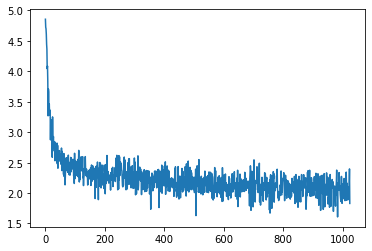

In [713]:
# %%prun

batch_size = 32
batch_len = 64

for batch in tqdm(it.islice(dl,1024)):
    # batch = torch.LongTensor([notes for notes in it.islice(gen_tracks(batch_len), batch_size)])
    opt.zero_grad()
    r = net(batch)
    nll = (-r['log_probs']).mean()
    nll.backward()
    opt.step()
    losses.append(nll.item())
plt.plot(losses)

In [745]:
torch.save?

Signature:
torch.save(
    obj,
    f: Union[str, os.PathLike, BinaryIO, IO[bytes]],
    pickle_module=<module 'pickle' from '/Users/victor/anaconda3/envs/event-predictor/lib/python3.9/pickle.py'>,
    pickle_protocol=2,
    _use_new_zipfile_serialization=True,
) -> None
Docstring:
save(obj, f, pickle_module=pickle, pickle_protocol=DEFAULT_PROTOCOL, _use_new_zipfile_serialization=True)

Saves an object to a disk file.

See also: :ref:`saving-loading-tensors`

Args:
    obj: saved object
    f: a file-like object (has to implement write and flush) or a string or
       os.PathLike object containing a file name
    pickle_module: module used for pickling metadata and objects
    pickle_protocol: can be specified to override the default protocol

.. note::
    A common PyTorch convention is to save tensors using .pt file extension.

.. note::
    PyTorch preserves storage sharing across serialization. See
    :ref:`preserve-storage-sharing` for more details.

.. note::
    The 1.6 release

In [ ]:
torch.save(net.state_dict()

In [714]:
%%time
acc = 0
m = 64
for _ in range(m):
    notes = random.choice(seqs)
    n = len(notes)-1
    net.reset()
    acc += sum(net.predict(notes[i])==notes[i+1] for i in range(n))/n
acc/m

CPU times: user 31.3 s, sys: 815 ms, total: 32.1 s
Wall time: 32.7 s


0.27318744628163827

In [715]:
batch_size*len(losses) / len(seqs)

0.7525088988402802

In [716]:
%%timeit
net.predict(0)

407 µs ± 22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [717]:
net_probs = []
for a in range(128):
    net.reset()
    b = net.predict(a, sample=False)
    net_probs.append(b)
net_probs = torch.stack(net_probs, 0)

Text(0.5, 1.0, 'P(b|a)')

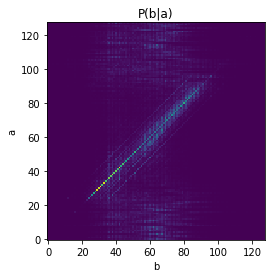

In [718]:
plt.imshow(net_probs.data, origin='lower', interpolation='nearest')
plt.ylabel('a')
plt.xlabel('b')
plt.title('P(b|a)')

# unigram baseline

In [719]:
counts = torch.zeros(128,128).long()
for s in seqs:
    counts[s[:-1], s[1:]] += 1

Text(0.5, 1.0, 'P(b|a)')

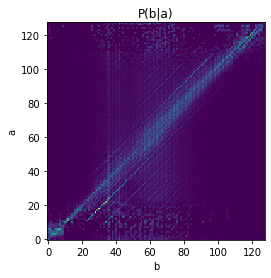

In [727]:
#P(b|a)
probs = counts / counts.sum(1,keepdims=True)
probs#[40:60, 40:60]
plt.imshow(probs, origin='lower', interpolation='nearest')
plt.ylabel('a')
plt.xlabel('b')
plt.title('P(b|a)')

<BarContainer object of 128 artists>

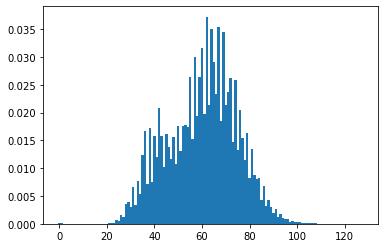

In [728]:
marg = counts.sum(1) / counts.sum()
plt.bar(range(128), marg, width=1)

In [729]:
# baseline accuracy
(probs.max(1).values * marg).sum()

tensor(0.0655)

<BarContainer object of 128 artists>

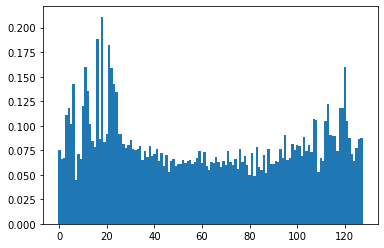

In [730]:
plt.bar(range(128), probs.max(1).values, width=1)